In [1]:
# !conda install -n arcgis -qy geopandas sqlalchemy geoalchemy2 psycopg2

In [2]:
import geopandas as gpd
import oracledb
import pickle
# import sys

# https://stackoverflow.com/questions/74093231/nosuchmoduleerror-cant-load-plugin-sqlalchemy-dialectsoracle-oracledb
# oracledb.version = "8.3.0"
# sys.modules["cx_Oracle"] = oracledb

from sqlalchemy import create_engine, event, Table, MetaData, Column, Index, PrimaryKeyConstraint
from sqlalchemy.dialects.oracle.base import ischema_names
from sqlalchemy.sql import quoted_name, text
from sqlalchemy.sql.functions import GenericFunction
from sqlalchemy.types import BLOB, NullType, Integer

from geoalchemy2.types import Geometry, _GISType
from geoalchemy2.elements import WKBElement

from pprint import pprint

# Table Reflection

## Parameters

In [3]:
src_schema_name = "litoestratigrafia"
src_table_name = "ue_layer_100000"

dst_schema_name = "public"
dst_table_name = src_table_name.replace("ue_layer", src_schema_name)
dst_table_pk = "fid"
dst_table_geom = "geom"

print(f"{dst_schema_name}.{dst_table_name}")

public.litoestratigrafia_100000


## Oracle Connection

In [4]:
oracledb.init_oracle_client()

with open("oracle-dsn.txt") as f:
    src_engine = create_engine(f.read())

## Check SDE Version

In [5]:
with src_engine.connect() as conn:
    _table = 'sde.sde_version'

    if conn.dialect.name == 'oracle':
        _table = 'sde.version'        

    major, minor, bugfix = conn.execute(
        text(f"SELECT major, minor, bugfix FROM {_table}"),
        
    ).fetchone()

print(f"ArcSDE: {major}.{minor}.{bugfix}")

ArcSDE: 10.1.0


## FeatureClass Props

In [6]:
%%time

verbose_table_name = f"{src_schema_name}.{src_table_name}"
table_props = {}

# https://desktop.arcgis.com/en/arcmap/latest/manage-data/using-sql-with-gdbs/
with src_engine.connect() as conn:
    # Primary key (RowID)
    table_props['pk'] = conn.execute(
        text("SELECT sde.gdb_util.rowid_name(:schema, :table) FROM DUAL"),
        {"table": src_table_name, "schema": src_schema_name}
    ).scalar()

    # table_props['is_archive'] = conn.execute(
    #     text("SELECT sde.gdb_util.IS_ARCHIVE_ENABLED(:schema, :table) FROM DUAL"),
    #     {"table": src_table_name.lower(), "schema": src_schema_name.lower()}
    # ).scalar()

    # If a table is not simple, it should not be edited outside ArcGIS.
    table_props['is_simple'] = conn.execute(
        text("SELECT sde.gdb_util.is_simple(:schema, :table) FROM DUAL"),
        {"table": src_table_name, "schema": src_schema_name}
    ).scalar()

    table_props['is_versioned'] = conn.execute(
        text("SELECT sde.gdb_util.IS_VERSIONED(:schema, :table) FROM DUAL"),
        {"table": src_table_name, "schema": src_schema_name}
    ).scalar()

    table_props['is_replicated'] = conn.execute(
        text("SELECT sde.gdb_util.is_replicated(:schema, :table) FROM DUAL"),
        {"table": src_table_name, "schema": src_schema_name}
    ).scalar()

pprint({verbose_table_name: table_props})

{'litoestratigrafia.ue_layer_100000': {'is_replicated': 'FALSE',
                                       'is_simple': 'TRUE',
                                       'is_versioned': 'FALSE',
                                       'pk': 'OBJECTID'}}
CPU times: user 5.68 ms, sys: 538 μs, total: 6.22 ms
Wall time: 183 ms


In [7]:
%%time

geometry_props = []

with src_engine.connect() as conn:
    geometries = [row[0] for row in conn.execute(
        text("SELECT sde.gdb_util.geometry_columns(:schema, :table) FROM DUAL"),
        {"table": src_table_name, "schema": src_schema_name}
    ).fetchall()]

    geometry_prop = {}
    
    for geometry in geometries:
        # column_name
        geometry_prop["name"] = geometry 

        # SRID
        geometry_prop['srid'] = conn.execute(
            text(f"SELECT DISTINCT sde.st_srid({geometry}) FROM {verbose_table_name}")
        ).scalar()

        # Geometry type
        _type = [row[0] for row in conn.execute(
            text(f"SELECT DISTINCT replace(replace(upper(sde.st_geometrytype({geometry})), 'ST_', ''), 'MULTI', '') FROM {verbose_table_name}")
        ).fetchall()]

        assert len(_type) > 0

        geometry_prop['type'] = _type[0] if len(_type) == 1 else 'GEOMETRYCOLLECTION'

        # Simple or multipart
        geometry_prop['is_multi'] = bool(conn.execute(
            text(f"SELECT max(sde.st_numgeometries({geometry})) FROM {verbose_table_name}")
        ).scalar() > 1)

        # Empty geometry
        geometry_prop['has_empty'] = any([row[0] for row in conn.execute(
            text(f"SELECT DISTINCT sde.st_isempty({geometry}) FROM {verbose_table_name}")
        ).fetchall()])

        # 3d
        geometry_prop['is_3d'] = any([row[0] for row in conn.execute(
            text(f"SELECT DISTINCT sde.st_is3d({geometry}) FROM {verbose_table_name}")
        ).fetchall()])

        # Measured
        geometry_prop['is_measured'] = any([row[0] for row in conn.execute(
            text(f"SELECT DISTINCT sde.st_ismeasured({geometry}) FROM {verbose_table_name}")
        ).fetchall()])
        
        # OGC Simple Feature
        geometry_prop['is_simple'] = all([row[0] for row in conn.execute(
            text(f"SELECT DISTINCT sde.st_issimple({geometry}) FROM {verbose_table_name}")
        ).fetchall()])

        geometry_props.append(geometry_prop)

table_props["geometry_columns"] = geometry_props

# Atestar que só tenha uma coluna de geometria
assert len(geometries) == 1

pprint(table_props)

{'geometry_columns': [{'has_empty': False,
                       'is_3d': False,
                       'is_measured': False,
                       'is_multi': True,
                       'is_simple': True,
                       'name': 'SHAPE',
                       'srid': 4326,
                       'type': 'POLYGON'}],
 'is_replicated': 'FALSE',
 'is_simple': 'TRUE',
 'is_versioned': 'FALSE',
 'pk': 'OBJECTID'}
CPU times: user 10 ms, sys: 1.56 ms, total: 11.6 ms
Wall time: 33.8 s


## DB Reflection

In [8]:
# Function to convert ST_Geometry to WKB
class SDEAsBinary(GenericFunction):
    type = BLOB
    name = quoted_name("SDE.ST_ASBINARY", False)
    identifier = "sde_asbinary"
    inherit_cache=True
    
# Function to convert text to ST_Geometry (Useless. Only for set property)
class SDEFromWKB(GenericFunction):
    type = Geometry
    name = quoted_name("SDE.ST_GEOMFROMWKB", False)
    identifier = "sde_fromwkb"
    inherit_cache=True
    
# Emulate ESRI Geometry Type
class STGeometry(_GISType):
    name = "shape"
    as_binary = SDEAsBinary.identifier
    from_text = SDEFromWKB.identifier
    ElementType = WKBElement
    cache_ok = False

ischema_names['ST_GEOMETRY'] = STGeometry

# Schema Metadata
src_metadata = MetaData(schema=src_schema_name)

# Get geometry props for reflection
src_geom_col = table_props["geometry_columns"][0]["name"].lower()
src_srid = table_props["geometry_columns"][0]["srid"]
src_table_pk = table_props["pk"].lower()
src_geom_type = table_props["geometry_columns"][0]["type"].upper()

if table_props["geometry_columns"][0]["is_multi"] and src_geom_type != "GEOMETRYCOLLECTION":
    src_geom_type = "MULTI" + src_geom_type

# Event handler for reflecting columns, for replace oracle to generalized ones
@event.listens_for(src_metadata, "column_reflect")
def genericize_datatypes(inspector, tablename, column_dict):
    # Checar Numeric com scale=0 e as_decimal=False: < 5 smallint 5 <= x <= 9, int; > 9 bigint
    if not type(column_dict["type"]) is NullType and column_dict["name"] != src_geom_col: 
        column_dict["type"] = column_dict["type"].as_generic()
    else: 
        column_dict["type"] = STGeometry(src_geom_type, srid=src_srid, spatial_index=False)

# New reflected table, from source
src_table = Table(
    src_table_name, 
    src_metadata, 
    autoload_with=src_engine, 
)

# Ignore SRC indexes
src_table.indexes = set()

### Check columns

In [9]:
pprint([column for column in src_table.columns])

[Column('objectid', Integer(), table=<ue_layer_100000>, nullable=False),
 Column('id_unidade_estratigrafica', Numeric(precision=11, scale=0, asdecimal=False), table=<ue_layer_100000>, nullable=False),
 Column('sigla', Unicode(length=180), table=<ue_layer_100000>, nullable=False),
 Column('hierarquia', Unicode(length=180), table=<ue_layer_100000>, nullable=False),
 Column('nome', Unicode(length=361), table=<ue_layer_100000>),
 Column('ambiente_tectonico', Unicode(length=180), table=<ue_layer_100000>),
 Column('sub_ambiente_tectonico', Unicode(length=180), table=<ue_layer_100000>),
 Column('sigla_pai', Unicode(length=180), table=<ue_layer_100000>),
 Column('nome_pai', Unicode(length=544), table=<ue_layer_100000>),
 Column('legenda', Unicode(length=2000), table=<ue_layer_100000>),
 Column('escala', Unicode(length=14), table=<ue_layer_100000>),
 Column('mapa', Unicode(length=255), table=<ue_layer_100000>, nullable=False),
 Column('litotipos', Text(), table=<ue_layer_100000>),
 Column('rang

### Select statement

In [10]:
pprint(str(src_table.select()))

('SELECT litoestratigrafia.ue_layer_100000.objectid, '
 'litoestratigrafia.ue_layer_100000.id_unidade_estratigrafica, '
 'litoestratigrafia.ue_layer_100000.sigla, '
 'litoestratigrafia.ue_layer_100000.hierarquia, '
 'litoestratigrafia.ue_layer_100000.nome, '
 'litoestratigrafia.ue_layer_100000.ambiente_tectonico, '
 'litoestratigrafia.ue_layer_100000.sub_ambiente_tectonico, '
 'litoestratigrafia.ue_layer_100000.sigla_pai, '
 'litoestratigrafia.ue_layer_100000.nome_pai, '
 'litoestratigrafia.ue_layer_100000.legenda, '
 'litoestratigrafia.ue_layer_100000.escala, '
 'litoestratigrafia.ue_layer_100000.mapa, '
 'litoestratigrafia.ue_layer_100000.litotipos, '
 'litoestratigrafia.ue_layer_100000.range, '
 'litoestratigrafia.ue_layer_100000.idade_min, '
 'litoestratigrafia.ue_layer_100000.idade_max, '
 'litoestratigrafia.ue_layer_100000.eon_min, '
 'litoestratigrafia.ue_layer_100000.eon_max, '
 'litoestratigrafia.ue_layer_100000.era_min, '
 'litoestratigrafia.ue_layer_100000.era_max, '
 'litoe

### Test connection & auto query

In [11]:
with src_engine.connect() as conn:
    for row in conn.execute(src_table.select()):
        print(row)
        break

(1591953745, 5863.0, 'PP4ca', 'Complexo', 'Complexo Caracol', None, None, None, None, 'Gnaisse indiferenciado, muscovita-gnaisse; Biotita gnaisse e epidoto biotita gnaisse de composição monzogranítica a sienogranítica, equigranular médi ... (84 characters truncated) ... osicional; Metatonalitos e metatrondhjemitos grossos, foliados a bandados. Idades de cristalização entre 2924 ± 2 Ma a 2948 ± 5 Ma (Pb-Pb em zircão).', '1:100.000', 'Carta geológica da folha Colônia São Lourenço', 'Biotita gnaisse, Gnaisse, Metatonalito, Metatrondhjemito', 'PP4', 1600.0, 1800.0, 'Proterozóico', 'Proterozóico', 'Paleoproterozóico', 'Paleoproterozóico', 'Estateriano', 'Estateriano', 'Inferior', 'Inferior', <WKBElement at 0x7f98b4570190; 0103000000010000006e000000e8bce283809f4cc080a8bbe5fce035c008365c81749f4cc0506c3ff854e135c0a8acf2794f9f4cc09000d28ab1e13 ... (3278 characters truncated) ... f4cc0f060738ae5e035c0e89eb8608c9f4cc030cacdb9d9e035c0809c92d48b9f4cc0007b284bd9e035c0c029dd448a9f4cc0c0d98f0fd8e035c0

## Export structure to pickle

In [12]:
with open(f'output/{verbose_table_name.replace(".", "-")}.pkl', 'wb') as f:
    pickle.dump(src_table, f)

## Export to Parquet

In [13]:
with src_engine.connect() as conn:
    geodata = (
        gpd.read_postgis(
            str(src_table.select()), 
            conn,
            geom_col = STGeometry.name,
            crs = src_srid
        )
        .rename_geometry(dst_table_geom)
        .rename(columns=lambda col: col.lower())
        .rename(columns={src_table_pk: dst_table_pk})
        .set_index(dst_table_pk)
    )

geodata.to_parquet(f'output/{verbose_table_name.replace(".", "-")}.parquet')

geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 61369 entries, 1591953745 to 1592935633
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_unidade_estratigrafica  61369 non-null  int64   
 1   sigla                      61369 non-null  object  
 2   hierarquia                 61369 non-null  object  
 3   nome                       61369 non-null  object  
 4   ambiente_tectonico         12513 non-null  object  
 5   sub_ambiente_tectonico     5448 non-null   object  
 6   sigla_pai                  29111 non-null  object  
 7   nome_pai                   29111 non-null  object  
 8   legenda                    60991 non-null  object  
 9   escala                     61369 non-null  object  
 10  mapa                       61369 non-null  object  
 11  litotipos                  59272 non-null  object  
 12  range                      61369 non-null  object  
 13  idade_min     

<Axes: >

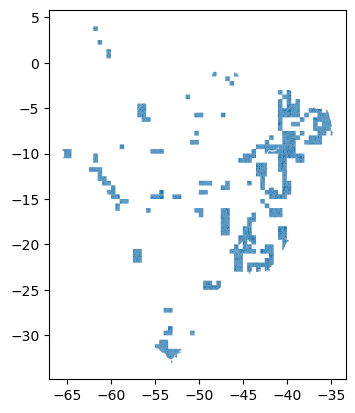

In [14]:
geodata.plot()

# Load to PostGIS

In [15]:
with open("postgres-dsn.txt") as f:
    dst_engine = create_engine(f.read(), connect_args={"application_name": "Jupyter Lab"})

with dst_engine.connect() as conn:
    print(
        conn.execute(text("SELECT postgis_version()")).scalar()
    )

3.2 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [16]:
dst_metadata = MetaData()

dst_table = src_table.to_metadata(
    dst_metadata, 
    schema=dst_schema_name, 
    name=dst_table_name
)

# Add geometry Index
Index(f"{dst_table_name}_geometry_gist", dst_table.columns[src_geom_col], postgresql_using="gist")

# Primary key
dst_table.primary_key = PrimaryKeyConstraint(dst_table.columns[src_table_pk], name=f"{dst_table_name}_pk")
dst_table.columns[src_table_pk].name = dst_table_pk
dst_table.columns[src_table_pk].autoincrement = False

# Geometry
dst_table.columns[src_geom_col].name = dst_table_geom
dst_table.columns[src_geom_col].type = Geometry(src_geom_type, srid=src_srid)
dst_table.columns[src_geom_col].key = dst_table_geom

# Create table on DB
dst_table.create(bind=dst_engine, checkfirst=True)

pprint([column for column in dst_table.columns])

[Column('fid', Integer(), table=<litoestratigrafia_100000>, key='objectid', primary_key=True, nullable=False),
 Column('id_unidade_estratigrafica', Numeric(precision=11, scale=0, asdecimal=False), table=<litoestratigrafia_100000>, nullable=False),
 Column('sigla', Unicode(length=180), table=<litoestratigrafia_100000>, nullable=False),
 Column('hierarquia', Unicode(length=180), table=<litoestratigrafia_100000>, nullable=False),
 Column('nome', Unicode(length=361), table=<litoestratigrafia_100000>),
 Column('ambiente_tectonico', Unicode(length=180), table=<litoestratigrafia_100000>),
 Column('sub_ambiente_tectonico', Unicode(length=180), table=<litoestratigrafia_100000>),
 Column('sigla_pai', Unicode(length=180), table=<litoestratigrafia_100000>),
 Column('nome_pai', Unicode(length=544), table=<litoestratigrafia_100000>),
 Column('legenda', Unicode(length=2000), table=<litoestratigrafia_100000>),
 Column('escala', Unicode(length=14), table=<litoestratigrafia_100000>),
 Column('mapa', Uni

In [17]:
# Write to PostGIS
with dst_engine.connect() as conn:
    geodata.to_postgis(dst_table_name, conn, schema=dst_schema_name, index=True, if_exists='append')

InvalidParameterValue: Geometry type (Polygon) does not match column type (MultiPolygon)
CONTEXT:  COPY litoestratigrafia_100000, line 1, column geom: "0103000020E6100000010000006E000000E8BCE283809F4CC080A8BBE5FCE035C008365C81749F4CC0506C3FF854E135C0A8..."


In [ ]:
geodata.geom.count_geometries().value_counts()

In [ ]:
# geometry_prop['type'] = _type[0] if len(_type) == 1 else 'GEOMETRYCOLLECTION'
with src_engine.connect() as conn:   

    result = conn.execute(
        text(f"SELECT max(sde.st_numgeometries({geometry})) FROM {verbose_table_name}")
    ).scalar()      
        #text(f"SELECT DISTINCT replace(replace(upper(sde.st_geometrytype({geometry})), 'ST_', ''), 'MULTI', '') FROM {verbose_table_name}")        
    # ).fetchall()

result > 1